# Airbnb NYC Occupancy - GLM (Jan2017)


## Imports

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.preprocessing import Imputer

In [5]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.iolib.smpickle import load_pickle

In [6]:
with open("../pickled_files/dfJan2017.pkl", 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [7]:
print(df.shape)

(40883, 125)


In [8]:
df['booked_30'] = 30 - df['availability_30'] # availability = 0 indicates fully booked, availability = 30 indicates not booked at all
df['booked_60'] = 60 - df['availability_60']
df['booked_90'] = 90 - df['availability_90']
df['booked_365'] = 365 - df['availability_365']

In [ ]:
# df.head(3)

In [ ]:
# plt.hist(df.booked_30);

30 indicates the listing is fully booked for the next 30 days
- Perhaps a representation of listings which are run like a hotel / business
- or, properties which are blocked off by host, only released on certain days

0 indicates the listing has full availability for the next 30 days


This suggests that either:
1. this listing is not a good one (in terms of price, quality, reviews), OR
2. this listing has not been updated for a while

In [ ]:
# plt.hist(df.booked_60);

In [ ]:
# plt.hist(df.booked_90);

In [ ]:
# plt.hist(df.booked_365);

## Filter outliers

### Inactive calendars
e.g. Listings which are booked out for 0 nights in the next 365 days
OR, booked out for all of the next 365 days.
--> Suspect these are inactive listings

In [9]:
df_cut1 = df[(df['booked_30'] != 0) & (df['booked_30'] != 30)]

In [10]:
df_cut1 = df_cut1.reset_index(drop=True)

In [11]:
print(len(df))
print(len(df_cut1))

40883
22306


### Outdated calendars

Calendars that haven't been updated for more than 7 weeks

In [12]:
updates = df.calendar_updated.unique().tolist()

In [13]:
frequent_updates = [x for x in updates if 'months' not in x]
acceptable_updates = [x for x in frequent_updates if x != 'never']

In [14]:
acceptable_updates

['5 weeks ago',
 '7 weeks ago',
 '3 days ago',
 'today',
 '2 weeks ago',
 'a week ago',
 '4 weeks ago',
 '4 days ago',
 '2 days ago',
 '6 days ago',
 '1 week ago',
 '3 weeks ago',
 '6 weeks ago',
 'yesterday',
 '5 days ago']

In [15]:
df_cut2 = df_cut1[df_cut1['calendar_updated'].isin(acceptable_updates)].reset_index()

In [16]:
print(len(df))
print(len(df_cut1))
print(len(df_cut2))

40883
22306
19400


### Luxury properties
Properties with price per night > $1k

In [ ]:
# plt.hist(df.price);

In [ ]:
# plt.hist(df[df['price'] < 1000].price);

In [17]:
df_cut3 = df_cut2[df_cut2['price'] < 1000]

In [18]:
df_cut3 = df_cut3.reset_index()

In [19]:
print(len(df))
print(len(df_cut1))
print(len(df_cut2))
print(len(df_cut3))

40883
22306
19400
19337


## Define X and y

In [20]:
columns = df.columns.tolist()
columns

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [21]:
dfGLM = df_cut3[[
    'price',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'entire_home',
 'private_room',
 'shared_room',
 'distance_from_NYC',
'zipcode_median_income',
    'booked_30',
    'availability_30'
                  ]]

In [22]:
print(dfGLM.shape)

(19337, 11)


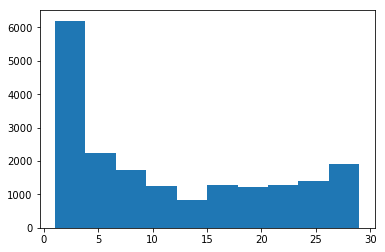

In [23]:
plt.hist(dfGLM.booked_30);

## Test-train split

In [24]:
dfTrain, dfTest = train_test_split(dfGLM, test_size=0.33, random_state=42)

In [25]:
print(dfTrain.shape)
print(dfTest.shape)

(12955, 11)
(6382, 11)


## Data imputation
### Check null values

In [26]:
def check_nulls(dataframe, features):
    contains_null = []
    for f in features:
        if dataframe[f].isnull().sum() > 0:
            contains_null.append(f)
    return contains_null

In [27]:
check_nulls(dfTrain, dfTrain.columns)

['bathrooms', 'bedrooms', 'zipcode_median_income']

In [28]:
check_nulls(dfTest, dfTest.columns)

['bathrooms', 'bedrooms', 'zipcode_median_income']

In [29]:
dfTrain.isnull().sum()

price                      0
accommodates               0
bathrooms                 35
bedrooms                  18
entire_home                0
private_room               0
shared_room                0
distance_from_NYC          0
zipcode_median_income    213
booked_30                  0
availability_30            0
dtype: int64

### Determine strategy

Evaluate which imputation strategy to use:

In [30]:
def modeVSmean(df, features):
    for f in features:
        print(f, "Mean: ", df[f].mean(), "Mode: ", df[f].mode()[0])

In [31]:
modeVSmean(df_cut3, ['bathrooms', 'bedrooms', 'zipcode_median_income'])

bathrooms Mean:  1.1239757286588528 Mode:  1.0
bedrooms Mean:  1.158908507223114 Mode:  1.0
zipcode_median_income Mean:  6341.946042597949 Mode:  3210.0


Features to impute with "most frequent" strategy:
- none

Features to impute with "mean" strategy:
- bathrooms
- bedrooms

### Build imputation pipeline

Define some custom transformers.

Reference: https://github.com/jem1031/pandas-pipelines-custom-transformers

In [32]:
class DFFeatureUnion(TransformerMixin):
    # FeatureUnion but for pandas DataFrames

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True, right_index=True), Xts)
        return Xunion

In [33]:
class ColumnExtractor(TransformerMixin):

    def __init__(self, cols):
        self.cols = cols

    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xcols = X[self.cols]
        return Xcols

In [34]:
class DFImputer(TransformerMixin):
    # Imputer but for pandas DataFrames

    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imp = None
        self.statistics_ = None

    def fit(self, X, y=None):
        self.imp = Imputer(strategy=self.strategy)
        self.imp.fit(X)
        self.statistics_ = pd.Series(self.imp.statistics_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Ximp = self.imp.transform(X)
        Xfilled = pd.DataFrame(Ximp, index=X.index, columns=X.columns)
        return Xfilled

In [35]:
dfTrain.columns

Index(['price', 'accommodates', 'bathrooms', 'bedrooms', 'entire_home',
       'private_room', 'shared_room', 'distance_from_NYC',
       'zipcode_median_income', 'booked_30', 'availability_30'],
      dtype='object')

In [36]:
ready_features = [ 'price','accommodates',
 'entire_home',
 'private_room',
 'shared_room',
 'distance_from_NYC', 'booked_30', 'availability_30'
]

set1 = ['bathrooms', 'bedrooms', 'zipcode_median_income']

In [37]:
imp_pipeline = Pipeline([
    ('features_to_be_imputed', DFFeatureUnion([
        ('features_ready', Pipeline([
            ('extract', ColumnExtractor(ready_features))
        ])),
        ('features_set1', Pipeline([
            ('extract', ColumnExtractor(set1)),
            ('mean_fill', DFImputer(strategy = 'mean'))
        ]))
    ])),
])

In [38]:
imp_pipeline.fit(dfTrain)

dfTrainImputed = imp_pipeline.transform(dfTrain)
dfTestImputed = imp_pipeline.transform(dfTest)

## GLM (Binomial)

In [39]:
formula = """booked_30 + availability_30 ~ price + accommodates + entire_home + private_room + shared_room + distance_from_NYC + zipcode_median_income + bathrooms + bedrooms"""

response_train, predictors_train = dmatrices(formula, dfTrainImputed, return_type='dataframe')

In [40]:
GLM_binomial = sm.GLM(response_train, predictors_train, family=sm.families.Binomial()).fit()

In [41]:
response_test, predictors_test = dmatrices(formula, dfTest, return_type='dataframe')

### Predictions

In [42]:
dfTrainImputed['predicted_occupancy'] = GLM_binomial.predict(predictors_train)
dfTestImputed['predicted_occupancy'] = GLM_binomial.predict(predictors_test)

In [43]:
dfPredictions = pd.concat([dfTrainImputed, dfTestImputed])

In [44]:
dfPredictions['error'] = (dfPredictions['predicted_occupancy'] * 30) - dfPredictions['booked_30']

In [45]:
dfPredictions.head()

,price,accommodates,entire_home,private_room,shared_room,distance_from_NYC,booked_30,availability_30,bathrooms,bedrooms,zipcode_median_income,predicted_occupancy,error
18196,60.0,2,0,1,0,10.432541,3,27,1.0,1.0,3074.0,0.326082,6.782474
13952,303.0,4,1,0,0,3.502807,1,29,1.0,2.0,3210.0,0.395350,10.860501
2128,85.0,2,0,1,0,7.787786,7,23,1.0,1.0,21321.0,0.369351,4.080542
702,28.0,1,0,1,0,6.324552,29,1,1.0,1.0,3017.0,0.374367,-17.768994
1947,125.0,7,1,0,0,5.874482,5,25,1.0,2.0,2279.0,0.392257,6.767723


### Mean absolute error (days)

In [46]:
errors = dfPredictions.error.tolist()

In [47]:
errors_abs = [abs(e) for e in errors]

In [48]:
errors_without_nan = [e for e in errors_abs if np.isnan(e) == False]

In [49]:
len(errors_without_nan)

19203

In [50]:
mean_absolute_error = np.mean(errors_without_nan)
mean_absolute_error

8.1804404932078061

__Check which rows are brining up NaN predictions from model__

In [51]:
len(errors_abs)

19337

In [52]:
np.isnan(errors_abs).sum()

134

In [53]:
dfPredictions.isnull().sum()

price                      0
accommodates               0
entire_home                0
private_room               0
shared_room                0
distance_from_NYC          0
booked_30                  0
availability_30            0
bathrooms                  0
bedrooms                   0
zipcode_median_income      0
predicted_occupancy      134
error                    134
dtype: int64

In [54]:
dfPredictions[dfPredictions['predicted_occupancy'].isnull()].head()

,price,accommodates,entire_home,private_room,shared_room,distance_from_NYC,booked_30,availability_30,bathrooms,bedrooms,zipcode_median_income,predicted_occupancy,error
385,111.0,1,0,1,0,2.136842,12,18,2.5,1.0,6356.261105,NaN,NaN
9189,375.0,7,1,0,0,2.438837,27,3,2.0,2.0,6356.261105,NaN,NaN
2140,70.0,2,0,1,0,5.131104,23,7,1.0,1.0,6356.261105,NaN,NaN
10341,60.0,2,0,1,0,6.564515,28,2,1.0,1.0,6356.261105,NaN,NaN
12813,202.0,5,1,0,0,2.804634,21,9,1.0,2.0,6356.261105,NaN,NaN


## Pickle the model

In [ ]:
# GLM_binomial.save("../pickled_models/GLM_binomial_Jan17.pkl")